In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Data

In [2]:
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

print("Number of training examples:", train_data.shape[0])
print("Number of test examples:", test_data.shape[0])

Number of training examples: 60000
Number of test examples: 10000


**# Separate features and labels**

In [3]:
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values

X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

**Normalize the pixel values (scale to [0, 1])**

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

**Convert labels to one-hot encoding**

In [5]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

num_classes = 10
y_train_one_hot = one_hot_encode(y_train, num_classes)
y_test_one_hot = one_hot_encode(y_test, num_classes)

**Split the training data into training and validation sets**

In [6]:
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train, y_train_one_hot, test_size=0.1, random_state=42
)

## Defining Neural Network Components

**Dense Layer**

## Explanation:

### Initialization:
- **Weights (`self.w`):**
  - Initialized with a scaled random normal distribution.
  - `np.sqrt(2.0 / input_dim)`: He initialization, suitable for ReLU activations.

- **Biases (`self.b`):**
  - Initialized to zeros.

- **Gradients (`self.dw`, `self.db`):**
  - Placeholders for gradients computed during backpropagation.

### Adam Parameters:
- **First Moment Vectors (`self.m_w`, `self.m_b`):**
  - Moving averages of the gradients.

- **Second Moment Vectors (`self.v_w`, `self.v_b`):**
  - Moving averages of the squared gradients.

### Cache (`self.input`):
- Stores the input to the layer for use during backpropagation.

## Theory:

### Dense (Fully Connected) Layer:
- Each neuron receives input from all neurons in the previous layer.
- Computes `output = X * W + b`.

### He Initialization:
- Addresses the problem of vanishing/exploding gradients.
- Suitable for layers followed by ReLU activation.


### **Forward Pass Explanation:**
  - Computes the linear transformation.
  - Stores the input \( X \) for use in backpropagation.

**Mathematical Operation:**
  -  `output = X * W + b`.

### **Backward Pass Explanation**:

- **Gradients w.r.t Weights (`self.dw`):**
  - Computed as the dot product of the transposed input and `grad_output`.

- **Gradients w.r.t Biases (`self.db`):**
  - Sum of `grad_output` along the batch dimension.

- **Gradient w.r.t Input (`grad_input`):**
  - Propagated backward to previous layers.
  - Computed as the dot product of `grad_output` and transposed weights.

## Theory:
- Backpropagation involves computing the gradients of the loss with respect to each parameter.
- Uses the chain rule from calculus.

**Explanation for updating parameters:**
  - **Computing Moving Averages:**
    - `self.m_w`, `self.m_b`: Exponential moving averages of gradients (first moment).
    - `self.v_w`, `self.v_b`: Exponential moving averages of squared gradients (second moment).
  
  - **Bias Correction:**
    - Adjusts the moments to account for their initialization at zero.
    - `m_w_hat`, `v_w_hat`: Corrected moments.

  - **Parameter Updates:**
    - Updates weights and biases using the Adam update rule.

# Parameter Update Theory:

- **Adam Optimizer:**
  - Combines the advantages of both AdaGrad and RMSProp.

  - **First Moment Estimate (Mean):**
    - \( m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t \)

  - **Second Moment Estimate (Variance):**
    - \( v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \)

  - **Bias Correction:**
    - Adjusts for the initial bias towards zero moments.

  - **Parameter Update:**
    - \( \theta_t = \theta_{t-1} - \alpha \frac{m_t}{\sqrt{v_t} + \epsilon} \)

- **Parameters:**
  - `beta1` and `beta2`:
    - Hyperparameters controlling the decay rates of the moving averages.
    - Commonly set to `beta1=0.9` and `beta2=0.999`.

  - `epsilon`:
    - Small constant to prevent division by zero.

  - `t`:
    - Timestep, incremented after each parameter update.





In [7]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        # Initialize weights and biases
        self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.b = np.zeros((1, output_dim))
        
        # Gradients
        self.dW = None
        self.db = None
        
        # Adam parameters
        self.m_W = np.zeros_like(self.W)
        self.v_W = np.zeros_like(self.W)
        self.m_b = np.zeros_like(self.b)
        self.v_b = np.zeros_like(self.b)
        
        # Cache for backpropagation
        self.input = None
    
    def forward(self, X):
        self.input = X
        output = np.dot(X, self.W) + self.b
        return output
    
    def backward(self, grad_output):
        # Compute gradients
        self.dW = np.dot(self.input.T, grad_output)
        self.db = np.sum(grad_output, axis=0, keepdims=True)
        grad_input = np.dot(grad_output, self.W.T)
        return grad_input
    
    def update_params(self, learning_rate, beta1, beta2, epsilon, t):
        # Update weights and biases using Adam optimizer
        self.m_W = beta1 * self.m_W + (1 - beta1) * self.dW
        self.v_W = beta2 * self.v_W + (1 - beta2) * (self.dW ** 2)
        m_W_hat = self.m_W / (1 - beta1 ** t)
        v_W_hat = self.v_W / (1 - beta2 ** t)
        self.W -= learning_rate * m_W_hat / (np.sqrt(v_W_hat) + epsilon)
        
        self.m_b = beta1 * self.m_b + (1 - beta1) * self.db
        self.v_b = beta2 * self.v_b + (1 - beta2) * (self.db ** 2)
        m_b_hat = self.m_b / (1 - beta1 ** t)
        v_b_hat = self.v_b / (1 - beta2 ** t)
        self.b -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)


**Batch Normalization**

- **Scale Parameter (`self.gamma`):**
  - Learns how much to scale the normalized output.

- **Shift Parameter (`self.beta`):**
  - Learns how much to shift the normalized output.

- **`epsilon`:**
  - Small constant to prevent division by zero.

- **`momentum`:**
  - Controls the updating of running estimates.

- **Running Estimates:**
  - `self.running_mean` and `self.running_var`:
    - Used during inference to normalize data with global statistics.

- **Gradients and Caches:**
  - **Gradients (`self.dgamma`, `self.dbeta`):**
    - For updating `gamma` and `beta`.
  
  - **Caches:**
    - Stores intermediate variables needed for backpropagation.

- **Adam Parameters:**
  - For optimizing `gamma` and `beta`.


## Batch Normalization:
- Normalizes the input of each mini-batch to have zero mean and unit variance.
- Helps in stabilizing the learning process and allows for higher learning rates.
- Learns `gamma` and `beta` to restore the representation power.

### Forward Pass:
**Explanation:**
  - **Training Mode:**
    - **Compute Batch Statistics:**
      - Mean (`self.batch_mean`) and variance (`self.batch_var`) over the mini-batch.
      
    - **Normalize the Batch:**
      - Subtract mean and divide by standard deviation (`self.std_inv`).
      
    - **Scale and Shift:**
      - Apply learned `gamma` and `beta`.
      
    - **Update Running Estimates:**
      - For use during inference.

  - **Inference Mode:**
    - Uses the running mean and variance to normalize data.

**Theory:**
  - **Normalization Formula:**
    - \( \hat{X} = \frac{X - \mu_{\text{batch}}}{\sqrt{\sigma_{\text{batch}}^2 + \epsilon}} \)

  - **Scale and Shift:**
    - \( Y = \gamma \hat{X} + \beta \)

  - **Running Estimates:**
    - \( \text{running\_mean} = \text{momentum} \times \text{running\_mean} + (1 - \text{momentum}) \times \mu_{\text{batch}} \)
    - Similar for running variance.

## backward Pass
- **Explanation:**
  - **Gradients w.r.t Parameters:**
    - `self.dgamma`:
      - Gradient of the loss with respect to `gamma`.
    - `self.dbeta`:
      - Gradient of the loss with respect to `beta`.

  - **Gradient w.r.t Input (`dX`):**
    - Computed using chain rule and intermediate variables.
    - Ensures that gradients flow correctly through the normalization step.

- **Theory:**
  - **Backpropagation Through Batch Norm:**
    - Involves computing derivatives through the normalization and scaling steps.
    - Requires careful calculation to maintain numerical stability.


## update_params
- Similar to the Dense Layer, but updates `gamma` and `beta` parameters.
- Uses the Adam optimization algorithm for parameter updates.





In [8]:
class BatchNormalization:
    def __init__(self, input_dim, epsilon=1e-5, momentum=0.9):
        self.gamma = np.ones((1, input_dim))
        self.beta = np.zeros((1, input_dim))
        self.epsilon = epsilon
        self.momentum = momentum
        
        self.running_mean = np.zeros((1, input_dim))
        self.running_var = np.zeros((1, input_dim))
        
        # Gradients
        self.dgamma = None
        self.dbeta = None
        
        # Cache for backpropagation
        self.X_centered = None
        self.std_inv = None
        self.batch_mean = None
        self.batch_var = None
        
        # Adam parameters
        self.m_gamma = np.zeros_like(self.gamma)
        self.v_gamma = np.zeros_like(self.gamma)
        self.m_beta = np.zeros_like(self.beta)
        self.v_beta = np.zeros_like(self.beta)
    
    def forward(self, X, training=True):
        if training:
            self.batch_mean = np.mean(X, axis=0, keepdims=True)
            self.batch_var = np.var(X, axis=0, keepdims=True)
            
            self.X_centered = X - self.batch_mean
            self.std_inv = 1.0 / np.sqrt(self.batch_var + self.epsilon)
            
            X_norm = self.X_centered * self.std_inv
            out = self.gamma * X_norm + self.beta
            
            # Update running estimates
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        else:
            # Use running mean and var during inference
            X_centered = X - self.running_mean
            std_inv = 1.0 / np.sqrt(self.running_var + self.epsilon)
            X_norm = X_centered * std_inv
            out = self.gamma * X_norm + self.beta
        return out
    
    def backward(self, grad_output):
        N, D = grad_output.shape
        
        # Step-wise computation for gradients
        X_norm = self.X_centered * self.std_inv
        dX_norm = grad_output * self.gamma
        
        dvar = np.sum(dX_norm * self.X_centered * -0.5 * self.std_inv ** 3, axis=0)
        dmean = np.sum(dX_norm * -self.std_inv, axis=0) + dvar * np.mean(-2.0 * self.X_centered, axis=0)
        
        dX = (dX_norm * self.std_inv) + (dvar * 2.0 * self.X_centered / N) + (dmean / N)
        self.dgamma = np.sum(grad_output * X_norm, axis=0, keepdims=True)
        self.dbeta = np.sum(grad_output, axis=0, keepdims=True)
        
        return dX
    
    def update_params(self, learning_rate, beta1, beta2, epsilon, t):
        # Update gamma and beta using Adam optimizer
        self.m_gamma = beta1 * self.m_gamma + (1 - beta1) * self.dgamma
        self.v_gamma = beta2 * self.v_gamma + (1 - beta2) * (self.dgamma ** 2)
        m_gamma_hat = self.m_gamma / (1 - beta1 ** t)
        v_gamma_hat = self.v_gamma / (1 - beta2 ** t)
        self.gamma -= learning_rate * m_gamma_hat / (np.sqrt(v_gamma_hat) + epsilon)
        
        self.m_beta = beta1 * self.m_beta + (1 - beta1) * self.dbeta
        self.v_beta = beta2 * self.v_beta + (1 - beta2) * (self.dbeta ** 2)
        m_beta_hat = self.m_beta / (1 - beta1 ** t)
        v_beta_hat = self.v_beta / (1 - beta2 ** t)
        self.beta -= learning_rate * m_beta_hat / (np.sqrt(v_beta_hat) + epsilon)


**ReLU Activation**

## ReLU Activation
- **Forward Pass:**
  - `np.maximum(0, X)`:
    - Applies the ReLU function element-wise.
    - Sets all negative inputs to zero.

- **Backward Pass:**
  - **Gradient w.r.t Input (`grad_input`):**
    - For inputs where \( X > 0 \), gradient is unchanged.
    - For inputs where \( X \leq 0 \), gradient is zero.

- **Theory:**
  - **ReLU Function:**
    - \( \text{ReLU}(x) = \max(0, x) \)

  - **Derivative:**
    - \( \frac{d}{dx} \text{ReLU}(x) = \begin{cases} 1, & x > 0 \\ 0, & x \leq 0 \end{cases} \)


In [9]:
class ReLU:
    def __init__(self):
        self.input = None
    
    def forward(self, X):
        self.input = X
        return np.maximum(0, X)
    
    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input


## Dropout
- Regularization technique to prevent overfitting.
- During training, randomly drops units along with their connections.
- **Scaling**:
- - By scaling the activations during training, there's no need to adjust them during inference.
- **Parameters:**
  - `dropout_rate`:
    - Probability of dropping a neuron (setting its output to zero).

- **Forward Pass:**
  - **Training Mode:**
    - **Creating the Mask:**
      - Randomly sets neurons to zero with probability `dropout_rate`.
      - **Scaling:** Divides by \( (1 - \text{dropout_rate}) \) to keep the expected value of the activations the same.
      
    - **Applying the Mask:**
      - Multiplies the input \( X \) by the mask.

  - **Inference Mode:**
    - No dropout is applied during testing.

- **Backward Pass:**
  - **Gradient w.r.t Input (`grad_output * self.mask`):**
    - Propagates gradients only through the neurons that were not dropped during the forward pass.
- **Scaling**
  By scaling the activations during training, there's no need to adjust them during inference.


**Dropout**

In [10]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None
    
    def forward(self, X, training=True):
        if training:
            self.mask = (np.random.rand(*X.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
            return X * self.mask
        else:
            return X  # During inference, no dropout applied
    
    def backward(self, grad_output):
        return grad_output * self.mask


**Softmax and Cross-Entropy Loss**

In [11]:
def softmax_cross_entropy_loss(logits, labels):
    # logits: output of the network before softmax, shape (N, C)
    # labels: one-hot encoded true labels, shape (N, C)
    # returns loss and gradient with respect to logits
    
    # Compute softmax probabilities
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    softmax_probs = exps / np.sum(exps, axis=1, keepdims=True)
    
    # Compute loss
    N = logits.shape[0]
    loss = -np.sum(labels * np.log(softmax_probs + 1e-15)) / N
    
    # Compute gradient
    grad_logits = (softmax_probs - labels) / N
    return loss, grad_logits


## Building the Network Architecture

### Initialization:
- self.layers:
  - List of layers constituting the network.
- self.t:
  - Global timestep used for Adam optimizer.

### Forward Pass:
- Iterates through each layer, passing the output of one as the input to the next.
- **Conditional Forward Pass:**: For layers that behave differently during training and inference (Dropout, BatchNormalization), passes the training flag.

### Backward Pass:
- Iterates through layers in reverse order.
- Passes the gradient from one layer to the previous.

### Parameter Update:
- Updates parameters of each layer that has an `update_params` method.
- Increments the global timestep `self.t` after each update.

In [12]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.t = 1  # Timestep for Adam optimizer
    
    def forward(self, X, training=True):
        for layer in self.layers:
            if isinstance(layer, (Dropout, BatchNormalization)):
                X = layer.forward(X, training=training)
            else:
                X = layer.forward(X)
        return X
    
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
    
    def update_params(self, learning_rate, beta1, beta2, epsilon):
        for layer in self.layers:
            if hasattr(layer, 'update_params'):
                layer.update_params(learning_rate, beta1, beta2, epsilon, self.t)
        self.t += 1


## Network Structure:
- Input Layer: Receives flattened 28x28 images `(input_dim = 784)`.
  
### First Hidden Layer:
- Dense Layer: 512 units. 
- Batch Normalization.
- ReLU Activation.
- Dropout with 30% rate.

### Second Hidden Layer:
- Dense Layer: 256 units. 
- Batch Normalization.
- ReLU Activation.
- Dropout with 30% rate.

### Third Hidden Layer:
- Dense Layer: 128 units. 
- Batch Normalization.
- ReLU Activation.
- Dropout with 30% rate.

### Output Layer
- Dense Layer: 10 units (one for each class).



In [13]:
architectures = {
    'Arch1': {
        'layers': [
            {'units': 512},
            {'units': 256},
            {'units': 128},
        ],
    },
    'Arch2': {
        'layers': [
            {'units': 1024},
            {'units': 512},
            {'units': 256},
            {'units': 128},
        ],
    },
    'Arch3': {
        'layers': [
            {'units': 256},
            {'units': 128},
        ],
    },
}

## Training the Model

**Setting Hyperparameters**

- **Learning Rate (`learning_rate`):**
  - Step size for parameter updates.

- **Adam Hyperparameters:**
  - `beta1`: Decay rate for first moment estimates.
  - `beta2`: Decay rate for second moment estimates.
  - `epsilon`: Small constant to prevent division by zero.

- **Training Configuration:**
  - `num_epochs`: Number of times the entire training dataset is passed through the network.
  - `batch_size`: Number of samples processed before updating the model parameters.

In [14]:
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
num_epochs = 25  
batch_size = 64
dropout_rate = 0.3 
learning_rates = [0.005, 0.001, 0.0009, 0.0006]

best_test_accuracy = 0.0
best_model = None
best_model_info = {}

**Training the Network**

In [15]:
def train(network, X_train, y_train_one_hot, X_val, y_val_one_hot, num_epochs, batch_size, learning_rate):
    num_train_samples = X_train.shape[0]
    num_batches = int(np.ceil(num_train_samples / batch_size))
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1s = []
    val_f1s = []
    
    for epoch in range(num_epochs):
        # Shuffle the training data
        indices = np.arange(num_train_samples)
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_one_hot[indices]
        
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        all_predictions = []
        all_true_labels = []
        
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, num_train_samples)
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # Forward pass
            logits = network.forward(X_batch, training=True)
            
            # Compute loss and gradient
            loss, grad_logits = softmax_cross_entropy_loss(logits, y_batch)
            epoch_loss += loss
            
            # Backward pass
            network.backward(grad_logits)
            
            # Update parameters
            network.update_params(learning_rate, beta1, beta2, epsilon)
            
            # Compute accuracy
            predictions = np.argmax(logits, axis=1)
            true_labels = np.argmax(y_batch, axis=1)
            correct_predictions += np.sum(predictions == true_labels)
            total_samples += predictions.shape[0]
            
            all_predictions.extend(predictions)
            all_true_labels.extend(true_labels)
        
        # Compute average training loss and accuracy
        avg_train_loss = epoch_loss / num_batches
        train_accuracy = correct_predictions / total_samples
        train_f1 = f1_score(all_true_labels, all_predictions, average='macro')
        
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        train_f1s.append(train_f1)
        
        # Validation
        logits_val = network.forward(X_val, training=False)
        val_loss, _ = softmax_cross_entropy_loss(logits_val, y_val_one_hot)
        
        predictions_val = np.argmax(logits_val, axis=1)
        true_labels_val = np.argmax(y_val_one_hot, axis=1)
        val_accuracy = np.mean(predictions_val == true_labels_val)
        val_f1 = f1_score(true_labels_val, predictions_val, average='macro')
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.4f}, Training F1: {train_f1:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, "
              f"Validation F1: {val_f1:.4f}")
        
    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s

def plot_metrics(arch_name, learning_rate, train_losses, val_losses,
                 train_accuracies, val_accuracies, train_f1s, val_f1s):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title(f'Loss vs. Epochs ({arch_name}, Learning Rate: {learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_{arch_name}_lr_{learning_rate}.png')
    plt.close()
    
    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title(f'Accuracy vs. Epochs ({arch_name}, Learning Rate: {learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_{arch_name}_lr_{learning_rate}.png')
    plt.close()
    
    # Plot F1 Score
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_f1s, 'b-', label='Training F1 Score')
    plt.plot(epochs, val_f1s, 'r-', label='Validation F1 Score')
    plt.title(f'F1 Score vs. Epochs ({arch_name}, Learning Rate: {learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'f1_{arch_name}_lr_{learning_rate}.png')
    plt.close()

# def generate_confusion_matrix(network, X_test, y_test):
#     logits = network.forward(X_test, training=False)
#     predictions = np.argmax(logits, axis=1)
    
#     cm = confusion_matrix(y_test, predictions)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=range(10), yticklabels=range(10))
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.savefig('confusion_matrix.png')
#     plt.close()

def generate_confusion_matrix(network, X_test, y_test, arch_name, learning_rate):
    logits = network.forward(X_test, training=False)
    predictions = np.argmax(logits, axis=1)
    
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix - Architecture: {arch_name}, Learning Rate: {learning_rate}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Save the confusion matrix with architecture and learning rate in the filename
    filename = f'confusion_matrix_{arch_name}_lr_{learning_rate}.png'
    plt.savefig(filename)
    plt.close()



**Evaluating the Model**

In [16]:
def evaluate(network, X_test, y_test_one_hot):
    logits = network.forward(X_test, training=False)
    test_loss, _ = softmax_cross_entropy_loss(logits, y_test_one_hot)
    predictions = np.argmax(logits, axis=1)
    true_labels = np.argmax(y_test_one_hot, axis=1)
    test_accuracy = np.mean(predictions == true_labels)
    test_f1 = f1_score(true_labels, predictions, average='macro')
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")   
    return test_loss, test_accuracy, test_f1


## Executing for all

In [17]:
import pickle
model_results = []


for arch_name, arch_info in architectures.items():
    print(f"\nTraining models for architecture: {arch_name}")
    for lr in learning_rates:
        print(f"  Training with learning rate: {lr}")
        
        # Build the network for the current configuration
        layers = []
        input_dim = 784  # 28x28 images flattened
        for layer_info in arch_info['layers']:
            units = layer_info['units']
            
            # Dense layer
            layers.append(DenseLayer(input_dim, units))
            layers.append(BatchNormalization(units))
            layers.append(ReLU())
            
            # Apply dropout
            layers.append(Dropout(dropout_rate))
            
            # Update input dimension for next layer
            input_dim = units
        
        # Output layer
        layers.append(DenseLayer(input_dim, num_classes))
        
        # Initialize the network
        network = NeuralNetwork(layers)
        
        # Train the model and capture metrics
        train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = train(
            network, X_train, y_train_one_hot, X_val, y_val_one_hot, num_epochs, batch_size, lr
        )
        
        # Evaluate on the test set
        test_loss, test_accuracy, test_f1 = evaluate(network, X_test, y_test_one_hot)
        
        # Log the results
        model_info = {
            'architecture': arch_name,
            'learning_rate': lr,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'train_f1s': train_f1s,
            'val_f1s': val_f1s,
            'test_accuracy': test_accuracy,
            'test_f1': test_f1,
        }
        model_results.append(model_info)

        generate_confusion_matrix(network, X_test, y_test, arch_name, lr)
        
        # Check if this model is the best so far
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model = network
            best_model_info = model_info
        
        # Generate and save plots for this model
        plot_metrics(
            arch_name, lr, train_losses, val_losses,
            train_accuracies, val_accuracies, train_f1s, val_f1s
        )

# Save the best model using pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("*******************************************************************************************************************************")
print("\nBest Model:")
print(f"Architecture: {best_model_info['architecture']}")
print(f"Learning Rate: {best_model_info['learning_rate']}")
print(f"Test Accuracy: {best_model_info['test_accuracy']:.4f}")
print(f"Test F1 Score: {best_model_info['test_f1']:.4f}")
print("*******************************************************************************************************************************")


plot_metrics(
    best_model_info['architecture'],
    best_model_info['learning_rate'],
    best_model_info['train_losses'],
    best_model_info['val_losses'],
    best_model_info['train_accuracies'],
    best_model_info['val_accuracies'],
    best_model_info['train_f1s'],
    best_model_info['val_f1s']
)

# Generate confusion matrix for the best model with appropriate filename
generate_confusion_matrix(best_model, X_test, y_test, best_model_info['architecture'], best_model_info['learning_rate'])


# Log all test accuracies
print("*******************************************************************************************************************************")
print("\nAll Model Test Accuracies:")
for info in model_results:
    print(f"Architecture: {info['architecture']}, Learning Rate: {info['learning_rate']}, "
          f"Test Accuracy: {info['test_accuracy']:.4f}")


Training models for architecture: Arch1
  Training with learning rate: 0.005
Epoch 1/25, Training Loss: 0.5565, Training Accuracy: 0.8008, Training F1: 0.7989, Validation Loss: 0.3970, Validation Accuracy: 0.8510, Validation F1: 0.8485
Epoch 2/25, Training Loss: 0.4408, Training Accuracy: 0.8421, Training F1: 0.8410, Validation Loss: 0.3622, Validation Accuracy: 0.8670, Validation F1: 0.8634
Epoch 3/25, Training Loss: 0.3984, Training Accuracy: 0.8577, Training F1: 0.8568, Validation Loss: 0.3399, Validation Accuracy: 0.8723, Validation F1: 0.8719
Epoch 4/25, Training Loss: 0.3752, Training Accuracy: 0.8645, Training F1: 0.8635, Validation Loss: 0.3305, Validation Accuracy: 0.8748, Validation F1: 0.8781
Epoch 5/25, Training Loss: 0.3566, Training Accuracy: 0.8719, Training F1: 0.8710, Validation Loss: 0.2986, Validation Accuracy: 0.8847, Validation F1: 0.8854
Epoch 6/25, Training Loss: 0.3422, Training Accuracy: 0.8755, Training F1: 0.8747, Validation Loss: 0.3164, Validation Accuracy

In [18]:
import pickle

def save_model(model, filepath):
    model_params = {}
    for idx, layer in enumerate(model.layers):
        if isinstance(layer, DenseLayer):
            model_params[f'weight_{idx}'] = layer.W
            model_params[f'bias_{idx}'] = layer.b
    with open(filepath, 'wb') as file:
        pickle.dump(model_params, file)

save_model(best_model, 'best_model_str.pkl')

### Loading the best model and predict on the test set

Test Accuracy: 0.9047
Test F1 Score: 0.9050


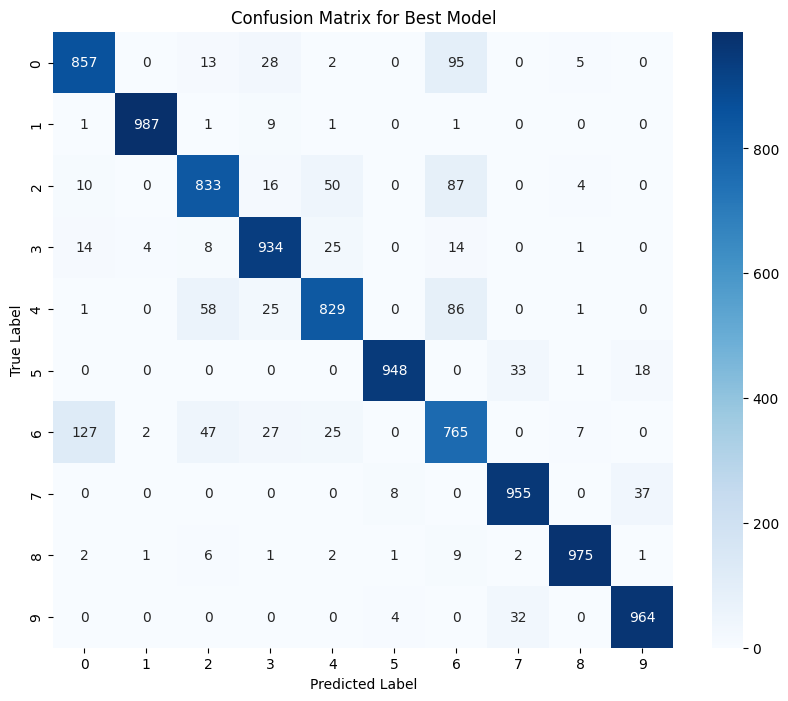

In [21]:
from sklearn.metrics import accuracy_score
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)


def evaluate_loaded_model(model, X_test, y_test_one_hot):
    
    logits = model.forward(X_test, training=False)
    
    predictions = np.argmax(logits, axis=1)
    true_labels = np.argmax(y_test_one_hot, axis=1)
    
    test_accuracy = accuracy_score(true_labels, predictions)
    test_f1 = f1_score(true_labels, predictions, average='macro')
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix for Best Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

evaluate_loaded_model(best_model, X_test, y_test_one_hot)